# 商务智能：Final Proj - MF
* 成员：
    * 吴越 2024211326    
    * 张铭轩 2024211332     
    * 卜方婧 2024211340

# Goal
* Extract user item rating information from the review dataset. Remove some ratings from this matrix, using matrix factorization to predict rating for these removed (user, item) pairs, and calculate mean absolute error.
   
# 步骤
* 数据预处理：
    * 提取product_reviews中user、product、score的信息，形成dataframe `data`; 
    * 随机删除10\%的数据，并在后续作为测试集评估模型性能。
* Matrix Factorization：
    * BiasSVD：无正则 & $L_2$正则
* 模型评估：
    * 使用MAE/MSE/RMSE作为衡量指标，在测试集上进行计算

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Flatten, Add
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping

In [2]:
# load data
data_train = pd.read_parquet("data_train.parquet")
data_test = pd.read_parquet("data_test.parquet")

data_train=data_train[["userId_encode","productId_encode","score"]]
data_test=data_test[["userId_encode","productId_encode","score"]]

# Matrix Factorization

## BiasSVD

BiasSVD 的预测模型为：


$$
\hat{r}_{ui} =  p_u^T q_i + b_u + b_i + b
$$


BiasSVD 的损失函数为（无正则化项）：

$$\sum_{(u,i): r_{ui}\neq null} \left( r_{ui} - \hat{r}_{ui} \right)^2$$


BiasSVD 的损失函数为（有$\sum_u\|p_u\|^2 + \sum_i \|q_i\|^2$ 正则化项）：

$$\sum_{(u,i): r_{ui}\neq null} \left( r_{ui} - \hat{r}_{ui} \right)^2 
+ \lambda \left( \sum_u\|p_u\|^2 + \sum_i \|q_i\|^2 \right)$$


BiasSVD 的损失函数为（有$\sum_u\|p_u\|^2 + \sum_i \|q_i\|^2 + \sum_u  b_u^2 +\sum_i b_i^2$ 正则化项）：

$$\sum_{(u,i): r_{ui}\neq null} \left( r_{ui} - \hat{r}_{ui} \right)^2 
+ \lambda \left( \sum_u\|p_u\|^2 + \sum_i \|q_i\|^2 + \sum_u  b_u^2 +\sum_i b_i^2  \right)$$



### BiasSVD无正则化

In [3]:
# 用户数和物品数
n_users = data_train["userId_encode"].unique().shape[0]
n_products = data_train["productId_encode"].unique().shape[0]
# 隐藏层节点数
n_factors = 5
# 学习率
lr = 0.01

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Embedding layers for users and items
user_embedding = Embedding(input_dim=n_users, output_dim=n_factors)(user_input)
item_embedding = Embedding(input_dim=n_products, output_dim=n_factors)(item_input)

# Flatten the embedding layers
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# Create the bias terms
user_bias = Embedding(input_dim=n_users, output_dim=1)(user_input)
item_bias = Embedding(input_dim=n_products, output_dim=1)(item_input)

user_bias_flat = Flatten()(user_bias)
item_bias_flat = Flatten()(item_bias)

# Dot product of user and item vectors
dot_product = Dot(axes=1)([user_vector, item_vector])

# Add the biases and dot product
prediction = Add()([dot_product, user_bias_flat, item_bias_flat])

# Define the model
model = Model(inputs=[user_input, item_input], outputs=prediction)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 5)                 827665    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 5)                 187560    ['input_2[0][0]']             
                                                                                              

In [4]:
# 将用户和物品转换为整数 ID
users = data_train["userId_encode"].values
products = data_train["productId_encode"].values
score = data_train["score"].values

# 创建并训练模型
history = model.fit([users, products], score, epochs=15, batch_size=256,validation_split=0.1)

Epoch 1/15
634/634 [==============================] - 9s 13ms/step - loss: 14.3186 - val_loss: 11.9606
Epoch 2/15
634/634 [==============================] - 8s 13ms/step - loss: 7.4075 - val_loss: 8.9762
Epoch 3/15
634/634 [==============================] - 9s 14ms/step - loss: 2.6609 - val_loss: 8.4019
Epoch 4/15
634/634 [==============================] - 7s 12ms/step - loss: 0.8703 - val_loss: 8.1814
Epoch 5/15
634/634 [==============================] - 8s 13ms/step - loss: 0.3315 - val_loss: 8.0774
Epoch 6/15
634/634 [==============================] - 7s 12ms/step - loss: 0.2010 - val_loss: 7.9188
Epoch 7/15
634/634 [==============================] - 9s 14ms/step - loss: 0.2238 - val_loss: 7.8012
Epoch 8/15
634/634 [==============================] - 8s 13ms/step - loss: 0.3093 - val_loss: 7.5382
Epoch 9/15
634/634 [==============================] - 9s 14ms/step - loss: 0.3621 - val_loss: 7.3634
Epoch 10/15
634/634 [==============================] - 8s 12ms/step - loss: 0.3540 - val_

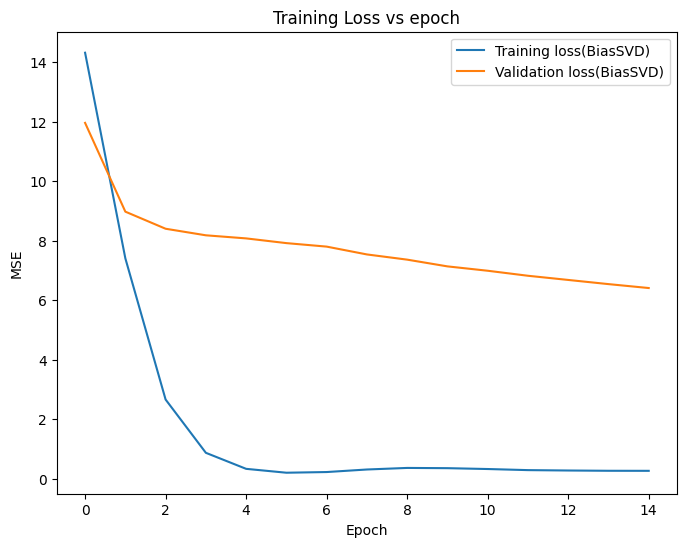

In [5]:
# Plot the learning curves
fig = plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss(BiasSVD)')
plt.plot(history.history['val_loss'], label='Validation loss(BiasSVD)')
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("MSE")
plt.title("Training Loss vs epoch")
plt.show()

In [6]:
# 预测用户对产品的评分
predicted_rating = model.predict([data_test["userId_encode"].values[:], data_test["productId_encode"].values[:]])  # 0 表示 user_1，1 表示 product_2
print(f'Predicted Rating: {predicted_rating}')

637/637 [==============================] - 1s 1ms/step
Predicted Rating: [[1.9638588]
 [4.506229 ]
 [2.104436 ]
 ...
 [2.7448437]
 [1.7000437]
 [2.7916026]]


In [9]:
bias_svd_mae_0=(abs(data_test["score"].values-predicted_rating.reshape(-1))).sum()/len(data_test)
bias_svd_mse_0=(((data_test["score"].values-predicted_rating.reshape(-1))**2).sum())/len(data_test)
bias_svd_rmse_0=np.sqrt(bias_svd_mse_0)
print("使用BiasSVD预测的MAE:",bias_svd_mae_0)
print("使用BiasSVD预测的MSE:",bias_svd_mse_0)
print("使用BiasSVD预测的RMSE:",bias_svd_rmse_0)

使用BiasSVD预测的MAE: 1.7334591196777516
使用BiasSVD预测的MSE: 4.703525477104974
使用BiasSVD预测的RMSE: 2.168761277113038


In [10]:
# 保存模型
model.save("bias_svd_model_no_regu.h5")

d:\ana\envs\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### BiasSVD有$\sum_u\|p_u\|^2 + \sum_i \|q_i\|^2$ 正则化 

In [11]:
# 用户数和物品数
n_users = data_train["userId_encode"].unique().shape[0]
n_products = data_train["productId_encode"].unique().shape[0]
# 隐藏层节点数
n_factors = 5
# 学习率
lr = 0.01
# 正则项系数
bias_svd_lambda = 0.1

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Embedding layers for users and items
user_embedding = Embedding(input_dim=n_users, output_dim=n_factors, 
                           embeddings_regularizer=l2(bias_svd_lambda))(user_input)
item_embedding = Embedding(input_dim=n_products, output_dim=n_factors, 
                           embeddings_regularizer=l2(bias_svd_lambda))(item_input)
# Flatten the embedding layers
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# Create the bias terms
user_bias = Embedding(input_dim=n_users, output_dim=1)(user_input)
item_bias = Embedding(input_dim=n_products, output_dim=1)(item_input)

user_bias_flat = Flatten()(user_bias)
item_bias_flat = Flatten()(item_bias)

# Dot product of user and item vectors
dot_product = Dot(axes=1)([user_vector, item_vector])

# Add the biases and dot product
prediction = Add()([dot_product, user_bias_flat, item_bias_flat])

# Define the model
model = Model(inputs=[user_input, item_input], outputs=prediction)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 5)                 827665    ['input_3[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 5)                 187560    ['input_4[0][0]']             
                                                                                            

In [12]:
# 将用户和物品转换为整数 ID
users = data_train["userId_encode"].values
products = data_train["productId_encode"].values
score = data_train["score"].values

# 创建并训练模型
history = model.fit([users, products], score, epochs=15, batch_size=256,validation_split=0.1)

Epoch 1/15
634/634 [==============================] - 10s 15ms/step - loss: 14.7826 - val_loss: 11.9544
Epoch 2/15
634/634 [==============================] - 11s 18ms/step - loss: 8.5863 - val_loss: 8.4197
Epoch 3/15
634/634 [==============================] - 12s 18ms/step - loss: 5.5601 - val_loss: 6.6574
Epoch 4/15
634/634 [==============================] - 11s 17ms/step - loss: 3.7657 - val_loss: 5.6514
Epoch 5/15
634/634 [==============================] - 11s 18ms/step - loss: 2.6001 - val_loss: 5.0295
Epoch 6/15
634/634 [==============================] - 12s 19ms/step - loss: 1.8029 - val_loss: 4.6254
Epoch 7/15
634/634 [==============================] - 12s 19ms/step - loss: 1.2434 - val_loss: 4.3555
Epoch 8/15
634/634 [==============================] - 11s 18ms/step - loss: 0.8483 - val_loss: 4.1728
Epoch 9/15
634/634 [==============================] - 12s 19ms/step - loss: 0.5682 - val_loss: 4.0478
Epoch 10/15
634/634 [==============================] - 11s 17ms/step - loss: 0.3

In [13]:
# 预测用户对产品的评分
predicted_rating = model.predict([data_test["userId_encode"].values[:], data_test["productId_encode"].values[:]])  # 0 表示 user_1，1 表示 product_2
print(f'Predicted Rating: {predicted_rating}')

637/637 [==============================] - 1s 808us/step
Predicted Rating: [[4.2267537]
 [5.095166 ]
 [1.85455  ]
 ...
 [3.1139169]
 [4.0082135]
 [4.674822 ]]


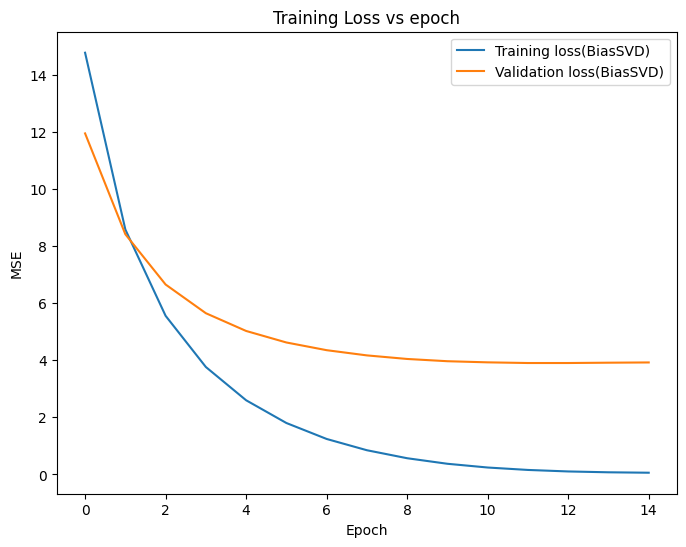

In [14]:
# Plot the learning curves
fig = plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss(BiasSVD)')
plt.plot(history.history['val_loss'], label='Validation loss(BiasSVD)')
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("MSE")
plt.title("Training Loss vs epoch")
plt.show()

In [18]:
bias_svd_mae=(abs(data_test["score"].values-predicted_rating.reshape(-1))).sum()/len(data_test)
bias_svd_mse=((data_test["score"].values-predicted_rating.reshape(-1))**2).sum()/len(data_test)
bias_svd_rmse=np.sqrt(bias_svd_mse)
print("使用BiasSVD预测的MAE:",bias_svd_mae)
print("使用BiasSVD预测的MSE:",bias_svd_mse)
print("使用BiasSVD预测的RMSE:",bias_svd_rmse)

使用BiasSVD预测的MAE: 0.961590217044084
使用BiasSVD预测的MSE: 1.9072885680078813
使用BiasSVD预测的RMSE: 1.3810461860516763


In [19]:
# 保存模型
model.save("bias_svd_model_regu.h5")

* 在当前超参下，加入正则化的BiasSVD预测效果比单纯的BiasSVD更好，可以有效防止模型过拟合
* 使用BiasSVD预测的MAE: 1.550458220460481
* 使用BiasSVD(有$\sum_u\|p_u\|^2 + \sum_i \|q_i\|^2$正则化)预测的MAE: 0.8741933453862178
* 尝试使用BiasSVD(有$\sum_u\|p_u\|^2 + \sum_i \|q_i\|^2+ \sum_u  b_u^2 +\sum_i b_i^2$正则化)，发现预测的效果不如无正则化